# When heteroskedasticity becomes problematic
# &
# How to fix it with variances

Author: Chenyu

Date: Apr 3, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
%matplotlib inline

sigma=10
x  = np.random.normal(loc=0, scale=sigma, size=1000) # N(0,10)
print(np.std(x), np.std(x/sigma))

10.2143531702283 1.02143531702283


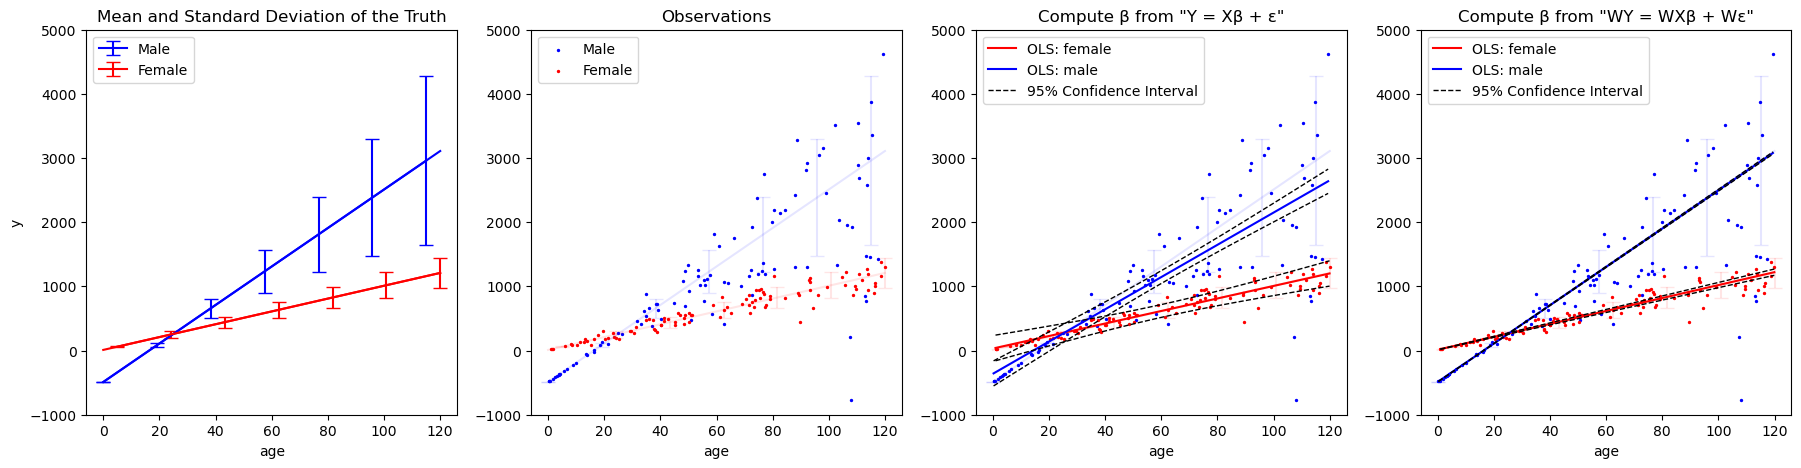

In [14]:
seed = 12
np.random.seed(seed)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)

X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=2*a)
        W[i,i] = (2*a)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 10
beta_age = 10
beta_sex = -500
beta_agexsex = 20
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 2*x_female_err

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend()

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend()
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend()
axes[2].set_title('Compute β from "Y = Xβ + ε"')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
predict_ci_low_sorted = np.matmul(W_inv,predict_ci_low)[sorting]
predict_ci_upp_sorted = np.matmul(W_inv,predict_ci_upp)[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend()
axes[3].set_title('Compute β from "WY = WXβ + Wε"')

# Uniform ylim
top = np.ceil(np.max(Y)/500)*500
bot = np.floor(np.min(Y)/500)*500
for axid in [0,1,2,3]:
    axes[axid].set_ylim(bottom=bot, top=top)

# Save fig
fig.savefig("/home/local/VANDERBILT/gaoc11/Projects/Variance-Aging-Diffusion/Figure/OLS_simulation/202304042037/{0}.png".format(seed), bbox_inches='tight')

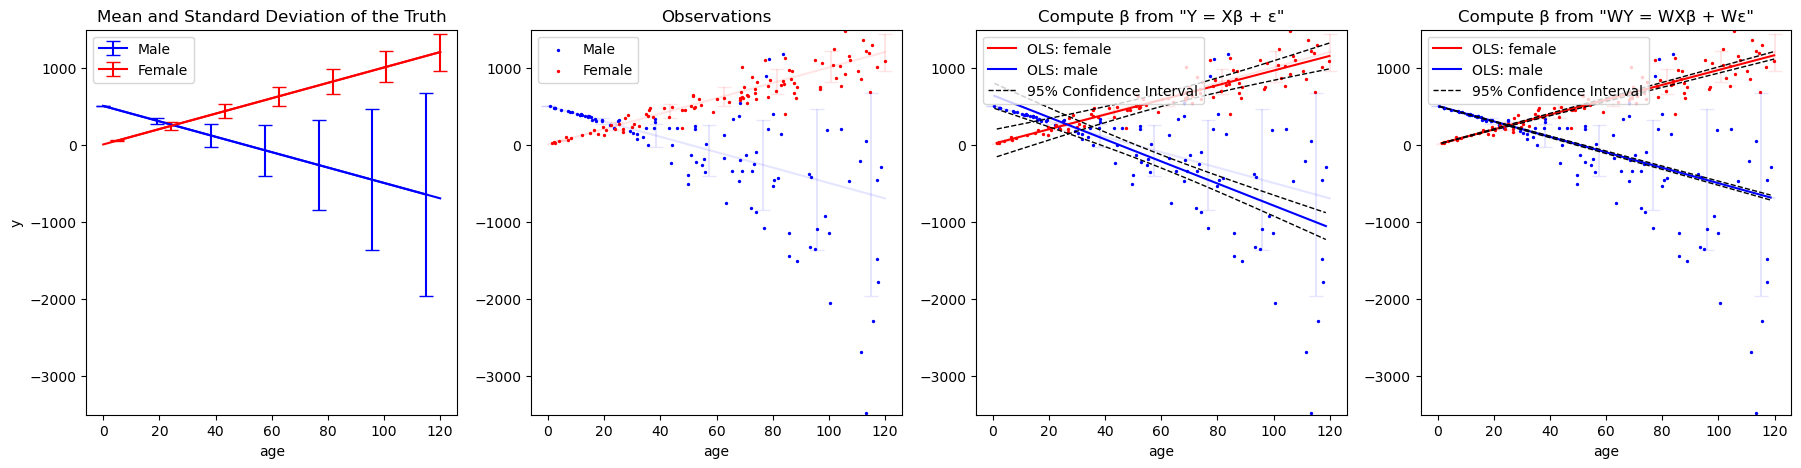

In [15]:
seed=0
np.random.seed(seed)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)
X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=2*a)
        W[i,i] = (2*a)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 10
beta_age = 10
beta_sex = 500
beta_agexsex = -20
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 2*x_female_err

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend()

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend()
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend()
axes[2].set_title('Compute β from "Y = Xβ + ε"')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
predict_ci_low_sorted = np.matmul(W_inv,predict_ci_low)[sorting]
predict_ci_upp_sorted = np.matmul(W_inv,predict_ci_upp)[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend()
axes[3].set_title('Compute β from "WY = WXβ + Wε"')

# Uniform ylim
top = np.ceil(np.max(Y)/500)*500
bot = np.floor(np.min(Y)/500)*500
for axid in [0,1,2,3]:
    axes[axid].set_ylim(bottom=bot, top=top)
    
# Save fig
fig.savefig("/home/local/VANDERBILT/gaoc11/Projects/Variance-Aging-Diffusion/Figure/OLS_simulation/202304042045/{0}.png".format(seed), bbox_inches='tight')

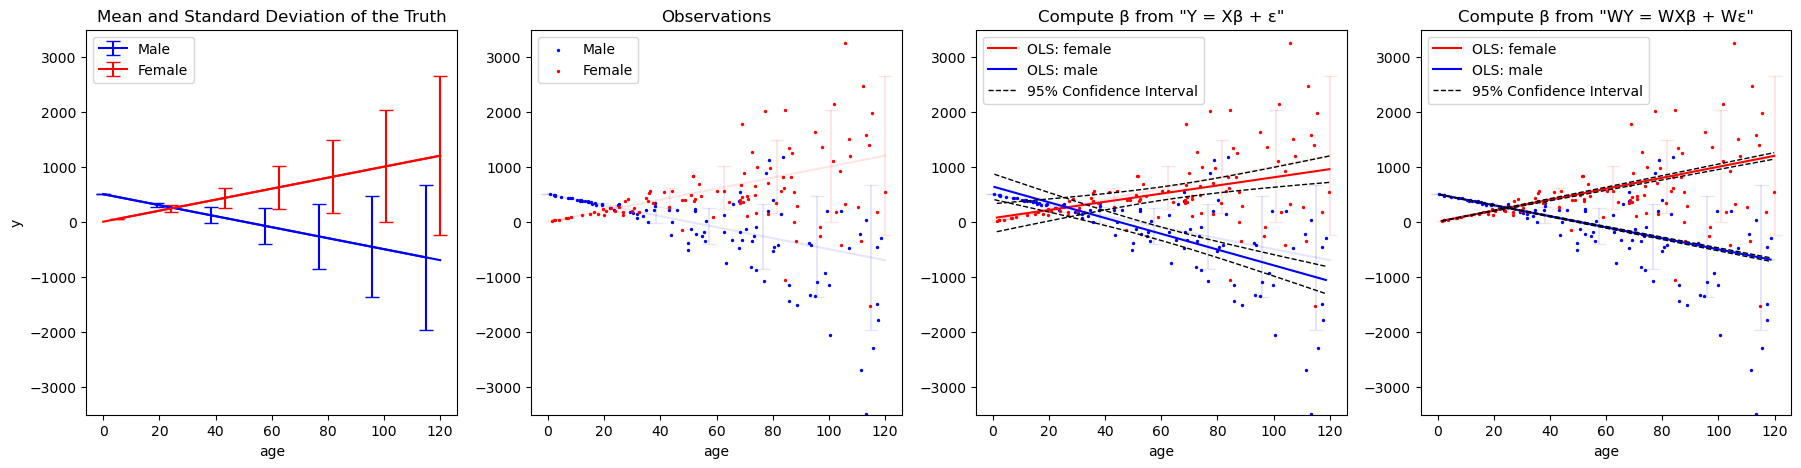

In [17]:
seed=0

np.random.seed(seed)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)
X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 10
beta_age = 10
beta_sex = 500
beta_agexsex = -20
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 0.1*x_female_err**2

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend()

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend()
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend()
axes[2].set_title('Compute β from "Y = Xβ + ε"')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
predict_ci_low_sorted = np.matmul(W_inv,predict_ci_low)[sorting]
predict_ci_upp_sorted = np.matmul(W_inv,predict_ci_upp)[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend()
axes[3].set_title('Compute β from "WY = WXβ + Wε"')

# Uniform ylim
top = np.ceil(np.max(Y)/500)*500
bot = np.floor(np.min(Y)/500)*500
for axid in [0,1,2,3]:
    axes[axid].set_ylim(bottom=bot, top=top)
    
# Save fig
fig.savefig("/home/local/VANDERBILT/gaoc11/Projects/Variance-Aging-Diffusion/Figure/OLS_simulation/202304042057/{0}.png".format(seed), bbox_inches='tight')

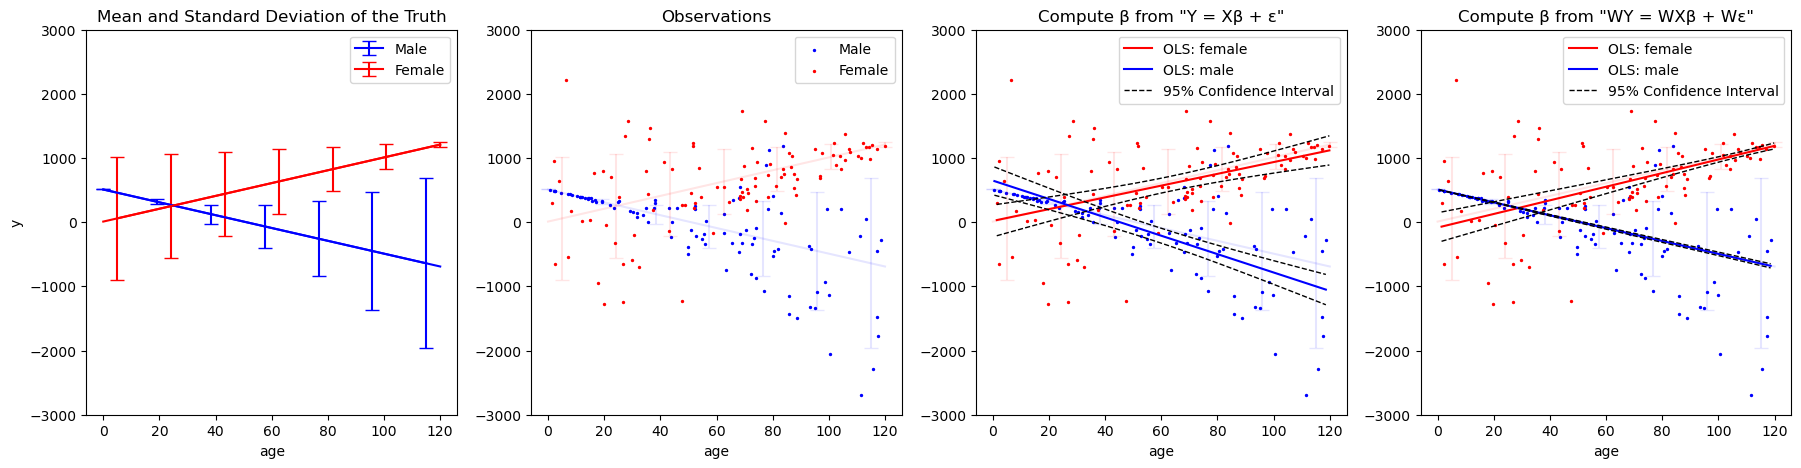

In [237]:
seed=0
np.random.seed(seed)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)
X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=1000-8*a)
        W[i,i] = (1000-8*a)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 10
beta_age = 10
beta_sex = 500
beta_agexsex = -20
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 1000-8*x_female_err

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend()

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend()
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend()
axes[2].set_title('Compute β from "Y = Xβ + ε"')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
predict_ci_low_sorted = np.matmul(W_inv,predict_ci_low)[sorting]
predict_ci_upp_sorted = np.matmul(W_inv,predict_ci_upp)[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend()
axes[3].set_title('Compute β from "WY = WXβ + Wε"')

# Uniform ylim
top = np.ceil(np.max(Y)/500)*500
bot = np.floor(np.min(Y)/500)*500
for axid in [0,1,2,3]:
    axes[axid].set_ylim(bottom=bot, top=top)

# Save fig
fig.savefig("/home/local/VANDERBILT/gaoc11/Projects/Variance-Aging-Diffusion/Figure/OLS_simulation/202304042105/{0}.png".format(seed), bbox_inches='tight')

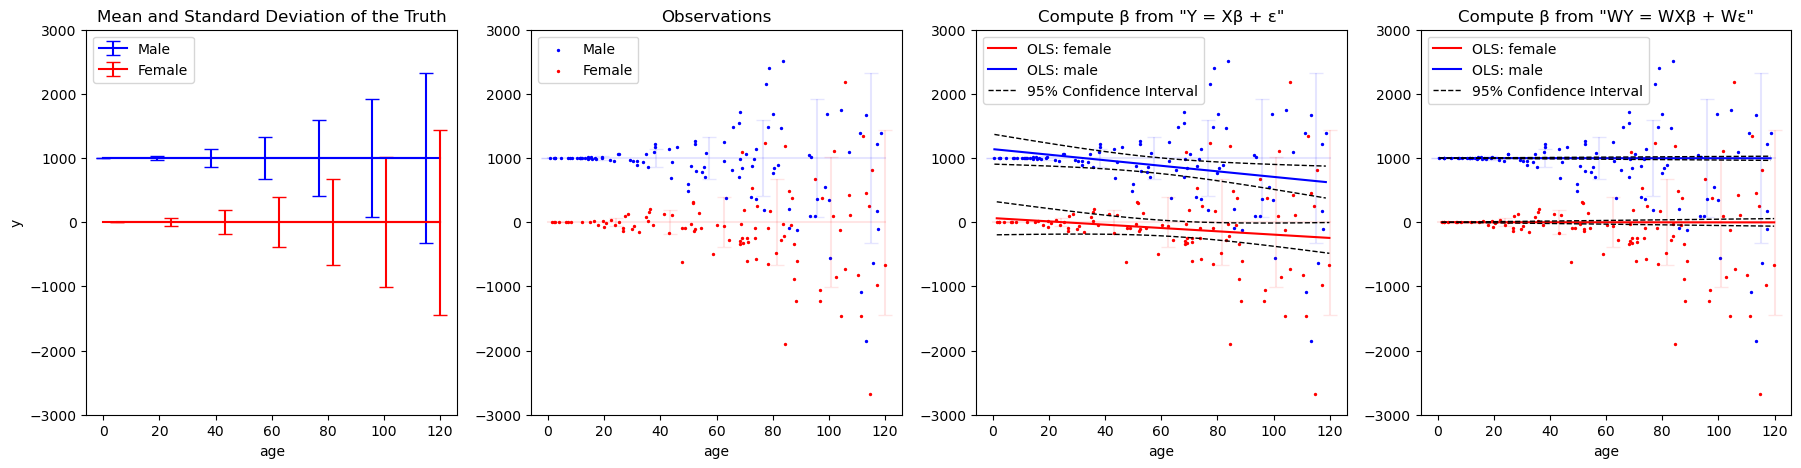

In [20]:
seed=0
np.random.seed(seed)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)
X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 0
beta_age = 0
beta_sex = 1000
beta_agexsex = 0
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 0.1*x_female_err**2

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend()

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend()
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend()
axes[2].set_title('Compute β from "Y = Xβ + ε"')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
predict_ci_low_sorted = np.matmul(W_inv,predict_ci_low)[sorting]
predict_ci_upp_sorted = np.matmul(W_inv,predict_ci_upp)[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend()
axes[3].set_title('Compute β from "WY = WXβ + Wε"')

# Uniform ylim
top = np.ceil(np.max(Y)/500)*500
bot = np.floor(np.min(Y)/500)*500
for axid in [0,1,2,3]:
    axes[axid].set_ylim(bottom=bot, top=top)

# Save fig
fig.savefig("/home/local/VANDERBILT/gaoc11/Projects/Variance-Aging-Diffusion/Figure/OLS_simulation/202304051001/{0}.png".format(seed), bbox_inches='tight')